In [1]:
### Loading the relevant package  ####
library(xts);library(caret);library(dplyr);library(zoo)
library(tidyverse);library(lubridate);library(data.table)
library(ggplot2);library(timeDate);library(Metrics);
library(hydroGOF);library(imputeTS);library(readxl);library(forecastML);library(neuralnet);
library(randomForest);library(glmnet)

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: lattice

Loading required package: ggplot2

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:xts’:

    first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.1.0     ✔ purrr   0.3.4
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::first()  masks xts::first()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::last()   masks 

In [2]:
## Data loading and cleaning  ##
## Reading the excel file, starting with 12 line and giving NA as None value
df <- read_xlsx('Data/Anand_Vihar_16_21.xlsx',skip = 12,na = "None")
## converting date into proper date format and selecting the relevant variable needed
df <- df %>% mutate(date = dmy_hm(`From Date`,tz="Asia/Kolkata"),PM25=`PM2.5`)%>%
select(date,PM25,AT,RH,WS,SR,WD)
head(df)

date,PM25,AT,RH,WS,SR,WD
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016-01-01 01:00:00,376.00,11.43,69.00,0.30,12.25,216.25
2016-01-01 02:00:00,480.50,11.28,71.50,0.35,12.58,230.92
2016-01-01 03:00:00,486.67,11.71,71.83,0.31,12.33,203.25
2016-01-01 04:00:00,441.17,11.13,73.08,0.30,12.75,126.92
2016-01-01 05:00:00,594.83,11.01,74.75,0.30,12.58,196.42
2016-01-01 06:00:00,441.33,11.49,74.17,0.37,13.83,80.58


In [3]:
## Converting the data into daily time series
hourly_df <- df %>%
  select(date, PM25) %>% # to check the model for PM2.5 replace PM2.5 by PM2.5
  # extract date features
  mutate(
    date = as.POSIXct(date, format = "%d-%m-%Y %H:%M"), #Date format
    hour = hour(date),
    day = day(date),
    month = month(date),
    year = year(date),
    PM2.5 = ifelse(PM25 <5 | PM25 >999 ,NA,PM25) ## Removing PM2.5 less than 5 and 999 
  ) %>%
  # from hourly to daily
  group_by(date,hour, day, month, year) %>% ## Use if in case one want to convert to daily, monthly
  summarise(PM25 = mean(PM2.5, na.rm = TRUE)) %>% ## 
  mutate(week = week(date))

## Putting NA if there are null values 
hourly_df$PM25[is.nan(hourly_df$PM25)] <- NA

`summarise()` has grouped output by 'date', 'hour', 'day', 'month'. You can override using the `.groups` argument.



In [4]:
######################## Seasonal Indexes #####################################

## We creating index of seasons from the data till 2020 end

seasonalIndex <- hourly_df %>% filter(date < as.Date("2021-1-01"))


############################### Hourly seasonality  #######################
hourly_s <- seasonalIndex %>% group_by(year, month, day,hour) %>%
  summarize(average = mean(PM25, na.rm = TRUE))

hourly_s$average[is.nan(hourly_s$average)] <- NA

## Spanning the year wise value column wise
hourly_s <- hourly_s %>% ungroup() %>%
  spread(year, average)
#head(hourly_s)

# Calcuating the mean hourly index over the years (Except first, second and third columns)
hourly_s$meanindex <- rowMeans(hourly_s[, -c(1,2,3)], na.rm = TRUE)

## Summary mean is the mean of Mean index
summary_mean <- hourly_s %>% ungroup() %>%
  summarize(summary_mean = mean(meanindex, na.rm = T))

## We merge the Summary mean with our old data frame 
hourly_s <- merge(hourly_s, summary_mean)

## Finally calculating the hourly index by mean index/ summary mean * 100
hourly_s <-
  hourly_s %>% mutate(hourlyindex = meanindex / summary_mean * 100)

#head(hourly_s)


`summarise()` has grouped output by 'year', 'month', 'day'. You can override using the `.groups` argument.



In [5]:
############################### daily seasonality  #######################
daily_s <- seasonalIndex %>% group_by(year, month, day) %>%
  summarize(average = mean(PM25, na.rm = TRUE))

daily_s$average[is.nan(daily_s$average)] <- NA

## Spanning the year wise value column wise
daily_s <- daily_s %>% ungroup() %>%
  spread(year, average)
#head(daily_s)

# Calcuating the mean daily index over the years (Except first and second columns)
daily_s$meanindex <- rowMeans(daily_s[, -c(1,2)], na.rm = TRUE)

## Summary mean is the mean of Mean index
summary_mean <- daily_s %>% ungroup() %>%
  summarize(summary_mean = mean(meanindex, na.rm = T))

## We merge the Summary mean with our old data frame 
daily_s <- merge(daily_s, summary_mean)

## Finally calculating the daily index by mean index/ summary mean * 100
daily_s <-
  daily_s %>% mutate(dailyindex = meanindex / summary_mean * 100)

#head(daily_s)
#plot(daily_s$dailyindex,type="l")

`summarise()` has grouped output by 'year', 'month'. You can override using the `.groups` argument.



In [6]:
############################### weekly seasonality ###########
weekly_s <- seasonalIndex %>%
  group_by(year, week) %>%
  summarize(average = mean(PM25, na.rm = TRUE))

## NA if the average in null
weekly_s$average[is.nan(weekly_s$average)] <- NA

## Spreading across weeks
weekly_s <- weekly_s %>% ungroup() %>%
  spread(year, average)

#head(weekly_s)

# Calcuating the mean weekly index over the years
weekly_s$meanindex <- rowMeans(weekly_s[, -1], na.rm = TRUE)

## Calculting summary means
summary_mean <- weekly_s %>% ungroup() %>%
  summarize(summary_mean = mean(meanindex, na.rm = T))

## Adding summary mean
weekly_s <- merge(weekly_s, summary_mean)

## Calculating weekly index
weekly_s <-
  weekly_s %>% mutate(weeklyindex = meanindex / summary_mean * 100)

#head(weekly_s)
#plot(weekly_s$weeklyindex)

`summarise()` has grouped output by 'year'. You can override using the `.groups` argument.



In [7]:
############################### monthly seasonality ##############################

## Grouping by year and month
monthly_s <- seasonalIndex %>%
  group_by(year, month) %>%
  summarize(average = mean(PM25, na.rm = TRUE))

## Adding NA values if there are any null values of any sort 
monthly_s$average[is.nan(monthly_s$average)] <- NA

## Spreading across months 
monthly_s <- monthly_s %>% ungroup() %>%
  spread(year, average)

#head(monthly_s)

# Calcuating the mean weekly index over the years (-1 to remove first column which is month)
monthly_s$meanindex <- rowMeans(monthly_s[, -1], na.rm = TRUE)

## Summary mean of the mean index
summary_mean <- monthly_s %>% ungroup() %>%
  summarize(summary_mean = mean(meanindex, na.rm = T))

## Merging the summary mean with the data frame
monthly_s <- merge(monthly_s, summary_mean)

## Adding the Monthly index
monthly_s <-
  monthly_s %>% mutate(monthlyindex = meanindex / summary_mean * 100)
#head(monthly_s)
#plot(monthly_s$monthlyindex)

`summarise()` has grouped output by 'year'. You can override using the `.groups` argument.



In [8]:
############# Join the indexes to original houly data

hourly_s <- hourly_s %>% select(month,day,hour,hourlyindex)
hourly_df <- hourly_df %>% left_join(hourly_s,by=c("month","day","hour"))

daily_s <- daily_s %>% select(month, day, dailyindex)
hourly_df <- hourly_df %>% left_join(daily_s, by = c("month", "day"))

monthly_s <- monthly_s %>% select(month, monthlyindex)
hourly_df <- hourly_df %>% left_join(monthly_s, by = c("month"))

weekly_s <- weekly_s %>% select(week, weeklyindex)
hourly_df <- hourly_df %>% left_join(weekly_s, by = c("week"))

head(hourly_df)
## Removing the unnecessary data frames 
rm(hourly_s)
rm(daily_s)
rm(monthly_s)
rm(weekly_s)
rm(summary_mean)
rm(seasonalIndex)
rm(df)


date,hour,day,month,year,PM25,week,hourlyindex,dailyindex,monthlyindex,weeklyindex
<dttm>,<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
2016-01-01 01:00:00,1,1,1,2016,376.00,1,330.1168,257.2039,169.4738,220.0537
2016-01-01 02:00:00,2,1,1,2016,480.50,1,352.0487,257.2039,169.4738,220.0537
2016-01-01 03:00:00,3,1,1,2016,486.67,1,340.7661,257.2039,169.4738,220.0537
2016-01-01 04:00:00,4,1,1,2016,441.17,1,307.7540,257.2039,169.4738,220.0537
2016-01-01 05:00:00,5,1,1,2016,594.83,1,320.9865,257.2039,169.4738,220.0537
2016-01-01 06:00:00,6,1,1,2016,441.33,1,249.3396,257.2039,169.4738,220.0537


In [9]:
################### Data manipulation using forecastML
## Fill_gaps is a function from forecatML to see if there are any missing timestamps it creates
## an evenly spaced data frame
hourly_ts <- fill_gaps(hourly_df, date_col = 1, frequency = "1 hour")

#hourly_ts$date <- NULL
hourly_ts$hour <- NULL
hourly_ts$day <- NULL
hourly_ts$month <- NULL
hourly_ts$week <- NULL
hourly_ts$year <- NULL
head(hourly_ts)


,date,PM25,hourlyindex,dailyindex,monthlyindex,weeklyindex
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2016-01-01 01:00:00,376.00,330.1168,257.2039,169.4738,220.0537
2,2016-01-01 02:00:00,480.50,352.0487,257.2039,169.4738,220.0537
3,2016-01-01 03:00:00,486.67,340.7661,257.2039,169.4738,220.0537
4,2016-01-01 04:00:00,441.17,307.7540,257.2039,169.4738,220.0537
5,2016-01-01 05:00:00,594.83,320.9865,257.2039,169.4738,220.0537
6,2016-01-01 06:00:00,441.33,249.3396,257.2039,169.4738,220.0537


In [47]:
## For the training per se we will try to train the model from 2019/2020 onwards, we are also filling the missing value using moving average of last 48 hour
hourly_ts_filtered <- hourly_ts %>% filter(date>=ymd("2019-01-01"))%>%na_ma(k=48,weighting = "simple")
dates <- hourly_ts_filtered$date
head(hourly_ts_filtered)

,date,PM25,hourlyindex,dailyindex,monthlyindex,weeklyindex
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2019-01-01 00:00:00,517.25,411.1348,257.2039,169.4738,220.0537
2,2019-01-01 01:00:00,531.25,330.1168,257.2039,169.4738,220.0537
3,2019-01-01 02:00:00,542.00,352.0487,257.2039,169.4738,220.0537
4,2019-01-01 03:00:00,547.50,340.7661,257.2039,169.4738,220.0537
5,2019-01-01 04:00:00,497.00,307.7540,257.2039,169.4738,220.0537
6,2019-01-01 05:00:00,467.50,320.9865,257.2039,169.4738,220.0537


In [48]:
## Training data is all the dates before 2021
data_train <- hourly_ts_filtered %>% filter(date <ymd('2021-01-01'))
## Testing data data is the dates after 2021
data_test <- hourly_ts_filtered %>% filter(date >ymd('2021-01-01'))
#head(data_test)

In [49]:
## Horizons define for how long you want to predict/forecast for
horizons <- c(1, 3, 6, 12,24)
## Lookbasck 
lookback <- c(1:6,12, 24,48)
## Removing date from the dataframe so that it can be trained
data_train$date <- NULL
## Now creating a training data frame with lookback 
data_train_lagged <-
  create_lagged_df(
    data_train, ## data frame
    type = "train", ## training 
    outcome_col = 1,## Output column is PM2.5(1) 
    horizons = horizons, ## Horizons is used if you want to predict for more than one hour
    date = dates[1:nrow(data_train)], ## basically selecting the 
    lookback = lookback,## Lookback of x hour
    dynamic_features = c("hourlyindex", "dailyindex", "monthlyindex", "weeklyindex"), ## dynamic features of index
    frequency = "1 hour" ## Frequency is 1 day
  )


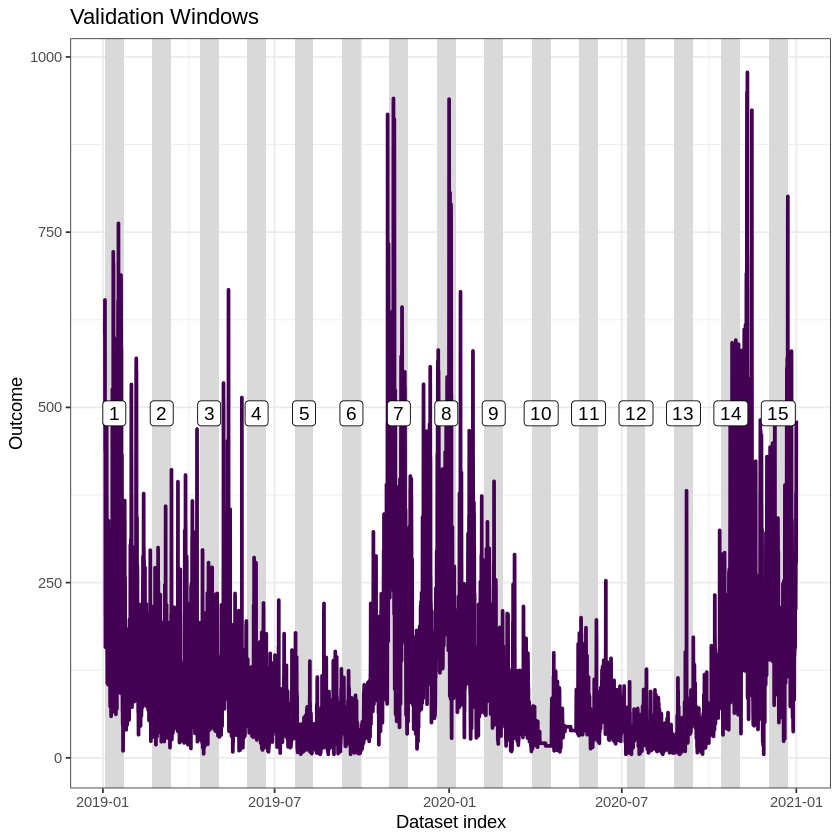

In [50]:
windows <- forecastML::create_windows(lagged_df = data_train_lagged, window_length = 480, skip = 720,
                                      window_start = NULL, window_stop = NULL,
                                      include_partial_window = TRUE)
plot(windows, data_train_lagged,show_labels = TRUE)

In [51]:
###################################### Linear Regression Model #################################

## Time is used to calculate the time running the process
start <- Sys.time()
# User-define model - Linear Regression
model_function_LinReg <- function(data, my_outcome_col) {
  outcome_names <- names(data)[my_outcome_col] ## The output column which you would like to predict PM2.5 in this case
  model_formula <- formula(paste0(outcome_names,  "~ .")) ## Model formulae in the format
  model <- lm(model_formula, data = data) ## Linear model in this case
  return(model)
}


In [52]:
##################### LASSO model ###########################

model_function_LASSO <- function(data, my_outcome_col) {
  
  ## Constant features basically all the independent variables
  constant_features <-
    which(unlist(lapply(data[, -(my_outcome_col)], function(x) {
      !(length(unique(x)) > 1)
    })))
  ## If the contant_feature is greater than 1  
  if (length(constant_features) > 1) {
    data <-
      data[, -c(constant_features + 1)]  # +1 because we're skipping over the outcome column.
  }
  
    ## All the columns except the dependent variables
  x <- data[, -(my_outcome_col), drop = FALSE]
    ## My dependent variables/outcome column
  y <- data[, my_outcome_col, drop = FALSE]
    ## Converting x into matrix
  x <- as.matrix(x, ncol = ncol(x))
    ## Converting y into matrix
  y <- as.matrix(y, ncol = ncol(y))
    ## Now training the lasso model
  model <- cv.glmnet(x, y)
  return(list("model" = model, "constant_features" = constant_features))
}


In [53]:

######################## Random Forest Model ###################################
# Alternatively, we could define an outcome column identifier argument, say, 'outcome_col = 1' in 
# this function or just 'outcome_col' and then set the argument as 'outcome_col = 1' in train_model().

model_function_RF <- function(data, my_outcome_col) {
  outcome_names <- names(data)[my_outcome_col] ## Output column that will be defined
  model_formula <- formula(paste0(outcome_names,  "~ .")) ## model formulae (like PM25 ~ .)
  set.seed(224) ## Setting the seed
  model <-
    randomForest(
      formula = model_formula, ## model_formulae
      data = data, ## the data
      ntree = 200, # try 100, 200, 300, 400, 500 and store the results
      mtry = 4, # try 2, 3, 4, 5
      na.action = na.omit ## Removing missing values if any
    )
}


In [54]:
model_results_LinReg <- forecastML::train_model(
  data_train_lagged, ## Training data
  windows = windows, ## The windows
  model_name = "LinReg", ## Linear Regressing
  model_function = model_function_LinReg, ## The model function
  my_outcome_col = 1, ## PM2.5 as an output column
  use_future = FALSE 
)
end <- Sys.time()
end-start

Time difference of 8.060424 secs

In [55]:
model_results_LASSO <- train_model(
  data_train_lagged, ## data_train 
  windows = windows, ## windows
  model_name = "LASSO", ## Model name as lasso
  model_function = model_function_LASSO, ## Model function is LASSO which we defined up
  my_outcome_col = 1, ## Output column in the first column in the dataframe which will also go in the model_function_LASSO
  use_future = FALSE  
)


In [ ]:
model_results_RF <- forecastML::train_model(
    data_train_lagged,
    windows=windows, 
    model_name = "RF", 
    model_function = model_function_RF, 
    use_future = FALSE)
end <- Sys.time()
end-start

In [24]:
## Defining the prediction function (Linear model)
prediction_function <- function(model, data_features) {
  data_pred <- data.frame("y_pred" = predict(model, data_features))
  return(data_pred)
}



In [25]:
## Prediction function for LASSO
prediction_function_LASSO <- function(model, data_features) {
  if (length(model$constant_features) > 1) {
    # 'model' was passed as a list.
    data_features <- data_features[, -c(model$constant_features)]
  }
  
  # data_features <- data_features[complete.cases(data_features), ]
  x <- as.matrix(data_features, ncol = ncol(data_features))
  data_pred <-
    data.frame("y_pred" = predict(model$model, x))
  return(data_pred)
}



In [26]:
## In forecast ML, one has to send model and function in a specific format 
data_results <- predict(model_results_LinReg, model_results_LASSO,model_results_RF, ## Models
                        prediction_function = list(prediction_function, prediction_function_LASSO,prediction_function),## Prediction Function 
                        data = data_train_lagged ) ## data

In [28]:
## We will calculate the error 
data_error <- forecastML::return_error(data_results,metrics=c("mae","rmse"),aggregate = "median")
## Will see the error 
head(data_error$error_global)
plot(data_error, facet = ~ horizon, type = "window")

,model,window_start,window_stop,mae,rmse
,<chr>,<dttm>,<dttm>,<dbl>,<dbl>
1,LASSO,2020-01-03,2020-01-03,25.68036,37.19459
2,LinReg,2020-01-03,2020-01-03,26.55301,37.48560
3,RF,2020-01-03,2020-01-03,21.67608,27.88006


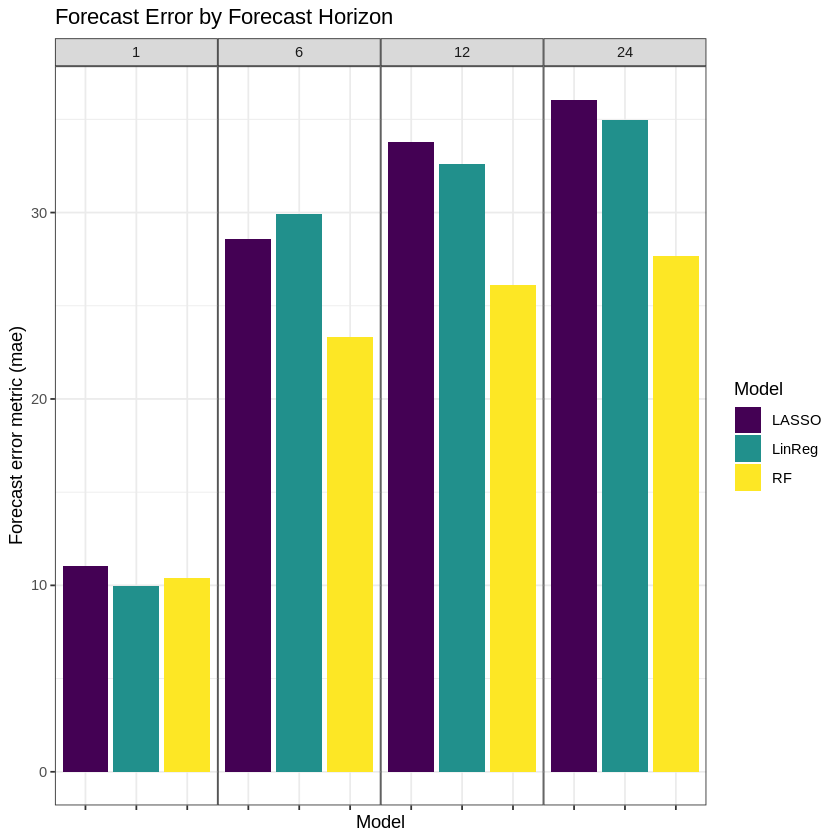

In [30]:
## Showing the error based on horizon
plot(data_error, type = "horizon", facet = ~ horizon, horizons = c(1, 6, 12,24))
## Showing the error across the windos anf facetted by horizon
plot(data_error, type = "global", facet = ~ horizon)

In [35]:
##  Now here we calculate the error metrics which we were not there (using the median across )
data_results %>% group_by(model,model_forecast_horizon,window_number)%>% ## Group by model, horizon and window 
summarize(R2=R2(PM25,PM25_pred),MAE=mae(PM25,PM25_pred),  ## Calculating error metrices 
          NMB=bias(PM25,PM25_pred)/mean(PM25),RMSE=rmse(PM25,PM25_pred),## Normalized RMSE and Bias we divide by mean
          RRMSE=rmse(PM25,PM25_pred)/mean(PM25))%>%
group_by(model,model_forecast_horizon)%>%  ## 
summarize(R2=median(R2),MAE=median(MAE),RMSE=median(RMSE),RRMSE=median(RRMSE),NMB=median(NMB))


`summarise()` has grouped output by 'model', 'model_forecast_horizon'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'model'. You can override using the `.groups` argument.



model,model_forecast_horizon,R2,MAE,RMSE,RRMSE,NMB
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LASSO,1,0.8460045,11.020124,15.70130,0.2306521,-0.014383302
LASSO,3,0.5082109,22.488043,30.94525,0.3691831,0.013344022
LASSO,6,0.3800544,28.606822,38.70323,0.4391568,0.030120166
LASSO,12,0.2996975,33.784683,44.28897,0.4630710,0.029728502
LASSO,24,0.2793607,36.047350,46.46502,0.4656505,0.020854806
LinReg,1,0.8538024,9.941819,15.11816,0.2250097,0.005792972
LinReg,3,0.4935517,22.765962,31.79148,0.3672337,0.019072504
LinReg,6,0.3765321,29.919925,40.91591,0.4230350,0.026103102
LinReg,12,0.2966525,32.614951,44.46055,0.4860211,0.033464959


In [29]:
If we want to save the model output 
#jpeg("Images/Model_comparison_training.jpeg", units="cm", width=36, height=15,res = 300)
#plot(data_error, type = "window", facet = ~ horizon, horizons = c(1, 6,12,24))
#dev.off()

In [40]:
horizons <- c(1, 3, 6, 12,24)
lookback <- c(1:6,12, 24,48)

data_forecast_list <- forecastML::create_lagged_df(data_train,
                                                   outcome_col = 1,
                                                   type = "forecast",
                                                   horizons = horizons,
                                                   lookback=lookback,
                                                   date = dates[1:nrow(data_train)],
                                                   frequency = "1 hour",
                                                   dynamic_features = c("hourlyindex", "dailyindex", "monthlyindex", "weeklyindex"), ## dynamic features of index
                                                   
                                                   )

In [41]:
dynamic_features <- c("hourlyindex", "dailyindex", "monthlyindex", "weeklyindex")
## This merge data is created to merge indexes and we are removing unnecessary columns 
merge_data <- hourly_df%>%ungroup(date)%>%select(-c(date,year,PM25))
for (i in seq_along(data_forecast_list)) {
    ## Adding date in the data frame horizons
  data_forecast_list[[i]]$date <-data_forecast_list[[i]]$index
  ##  Now adding the indexes from the merge data frame 
  data_forecast_list[[i]] <- data_forecast_list[[i]] %>%
    mutate(hour = hour(date),
    day = day(date),week = week(date),
    month = month(date),
    year = year(date)) %>%select(-dynamic_features)%>% ## First we need to remove these existing features
    left_join(merge_data,by=c("hour","day","week","month"))%>% ## Now we adding these features back using merge data frame 
    select(-c("hour","day","week","month","year","date"))%>%distinct()
    
}
rm(merge_data)
tail(data_forecast_list$horizon_1)

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(dynamic_features)` instead of `dynamic_features` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.



,index,horizon,PM25_lag_1,PM25_lag_2,PM25_lag_3,PM25_lag_4,PM25_lag_5,PM25_lag_6,PM25_lag_12,PM25_lag_24,PM25_lag_48,hourlyindex,dailyindex,monthlyindex,weeklyindex
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2021-01-01,1,481,415,361.5,324.75,304.75,278.5,294,225,150.5,411.1348,257.2039,169.4738,220.0537


In [42]:
## Now we see the forecast on forecast data list
data_forecast <- predict(model_results_LinReg,model_results_LASSO, model_results_RF,  # ... supports any number of ML models.
                         prediction_function = list(prediction_function,prediction_function_LASSO, prediction_function), 
                         data = data_forecast_list)

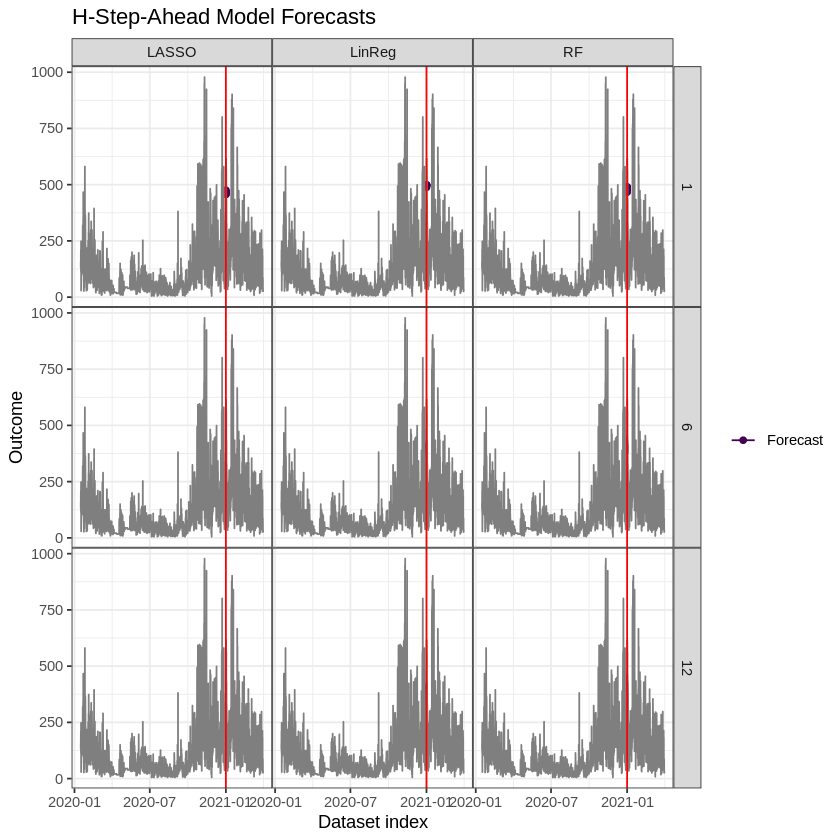

In [44]:
## Testing the forecast value 
plot(data_forecast,
     data_actual = hourly_ts_filtered[-(1:360),],  # Actuals from the training and test data sets.
     actual_indices = dates[-(1:360)], 
     horizons = c(1, 6, 12))

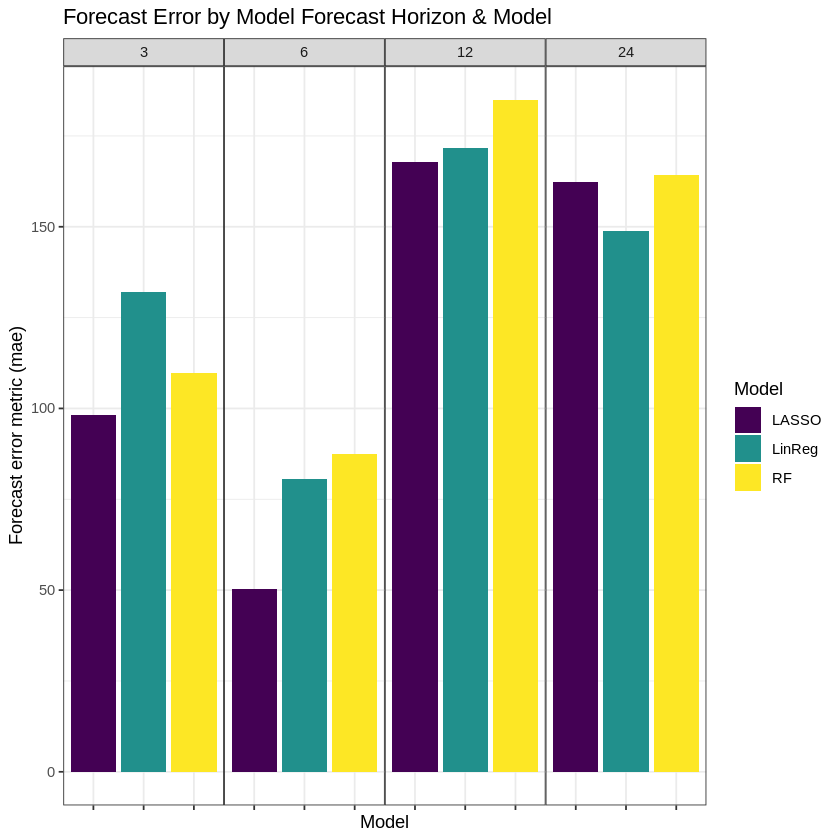

In [45]:
## Testing the model results on the forecast
data_error_forecast <- forecastML::return_error(data_forecast,
                                       data_test = data_test,
                                       test_indices = dates[(nrow(data_train) + 2):length(dates)])
## Plotting the error 
plot(data_error_forecast, facet = ~ horizon, type = "horizon")

In [66]:
## If we want to 
#object.size(data_results)
#save(data_results, file = "Model_output/data_results.Rdata")
#save(data_error, file = "Model_output/data_error.Rdata")
#save.image(file = "Model_output/Multi_step_forecast.RData") 

3352880 bytes